# PLATON: PLanetary Atmospheric Transmission for Observer Noobs 

PLATON is an exoplanetary atmospheric retreival code 


In [89]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
%matplotlib inline

In [91]:
from __future__ import print_function

from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

from multiprocessing import Pool, cpu_count

import os

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

In [92]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (5,5)

In [93]:
try:
    import nestle
except:
    !pip install nestle
    import nestle

In [94]:
try:
    from pygtc import plotGTC
except:
    !pip install git+https://github.com/exowanderer/pygtc
    from pygtc import pygtc

In [95]:
try:
    import platon
    del platon
except:
    !pip install git+https://github.com/ideasrule/platon

In [96]:
from datetime import datetime

from pandas import DataFrame
from platon.fit_info import FitInfo
from platon.retriever import Retriever
from platon.constants import R_sun, R_jup, M_jup
from platon.constants import METRES_TO_UM
from platon.transit_depth_calculator import TransitDepthCalculator
from platon.errors import AtmosphereError

from sklearn.externals import joblib

In [ ]:
def compute_new_model(result, fit_info, bayesian_model='emcee', wave_min=0.2e-6, wave_max=9.0e-6, n_theory_pts=500, include_condensation=True):

    wavelengths_theory = np.linspace(wave_min, wave_max, n_theory_pts)
    half_diff_lam = 0.5*np.median(np.diff(wavelengths_theory))

    # Setup calculator to use the theoretical wavelengths
    calculator = TransitDepthCalculator(include_condensation=include_condensation)
    calculator.change_wavelength_bins(np.transpose([wavelengths_theory-half_diff_lam, wavelengths_theory+half_diff_lam]))

    retriever._validate_params(fit_info, calculator)

    # Allocate the best-fit parameters from the `result` class
    if bayesian_model == 'multinest':
        best_params_arr = result.samples[np.argmax(result.logl)]
    elif bayesian_model == 'emcee':
        best_params_arr = result.flatchain[np.argmax(result.flatlnprobability)]
    else:
        raise ValueError("Options for `bayesian_model` (-bm, --bayesianmodel) must be either 'multinest' or 'emcee'")

    best_params_dict = {key:val for key,val in zip(fit_info.fit_param_names, best_params_arr)}

    # Set the static parameteres to the default values
    for key in fit_info.all_params.keys():
        if key not in best_params_dict.keys():
            best_params_dict[key] = fit_info.all_params[key].best_guess

    # Assign the best fit model parameters to necessary variables
    Rs = best_params_dict['Rs']
    Mp = best_params_dict['Mp']
    Rp = best_params_dict['Rp']
    T_eq = best_params_dict['T']
    logZ = best_params_dict['logZ']
    CO_ratio = best_params_dict['CO_ratio']
    log_cloudtop_P = best_params_dict['log_cloudtop_P']
    log_scatt_factor = best_params_dict['log_scatt_factor']
    scatt_slope = best_params_dict['scatt_slope']
    error_multiple = best_params_dict['error_multiple']
    T_star = best_params_dict['T_star']

    T_spot = best_params_dict['T_spot']
    spot_cov_frac = best_params_dict['spot_cov_frac']
    frac_scale_height = best_params_dict['frac_scale_height']
    log_number_density = best_params_dict['log_number_density']
    log_part_size = best_params_dict['log_part_size']
    part_size_std = best_params_dict['part_size_std']
    ri = best_params_dict['ri']

    # Compute best-fit theoretical model
    try:
        wavelengths, calculated_depths = calculator.compute_depths(
            Rs, Mp, Rp, T_eq, logZ, CO_ratio,
            scattering_factor=10**log_scatt_factor, scattering_slope=scatt_slope,
            cloudtop_pressure=10**log_cloudtop_P, T_star=T_star)
        
        return wavelengths, calculated_depths
    except AtmosphereError as error_message:
        return str(error_message)

In [ ]:
def plot_high_res_model_and_data(wave_data, t_depths, td_errors, result, fit_info, bayesian_model='emcee', wave_min=0.2e-6, wave_max=9.0e-6, n_theory_pts=500, include_condensation=True):
    # Plot the data on top of the best fit high-resolution model
    
    wave_min = wave_data.min()
    wave_max = wave_data.max()
    
    computed_model = compute_new_model(result=result, fit_info=fit_info, bayesian_model=bayesian_model, 
                                                       wave_min=wave_min, wave_max=wave_max, n_theory_pts=n_theory_pts, 
                                                       include_condensation=include_condensation)

    if isinstance(computed_model,str):
        raise AtmosphereError(computed_model)
    else:
        wavelengths, calculated_depths = computed_model
    
    plt.figure(figsize=(10,5))
    plt.errorbar(METRES_TO_UM * wave_data, t_depths, yerr=td_errors, fmt='.', color='k', zorder=100)
    plt.plot(METRES_TO_UM * wavelengths, calculated_depths)

    plt.xlabel("Wavelength (um)")
    plt.ylabel("Transit depth")
    plt.xscale('log')

    plt.tight_layout()

    if bayesian_model == 'multinest':
        plt.savefig('multinest_best_fit_{}.png'.format(time_stamp))
    elif bayesian_model == 'emcee':
        plt.savefig('emcee_best_fit_{}walkers_{}steps_{}.png'.format(nwalkers, nsteps, time_stamp))
    else:
        raise ValueError("Options for `bayesian_model` (-bm, --bayesianmodel) must be either 'multinest' or 'emcee'")

In [ ]:
def plot_gtc_platon(result, fit_info, time_stamp='NotGiven', 
                    bayesian_model='emcee', fit_param_names=None, 
                    nContourLevels=3, label_fontsize=10, 
                    tick_fontsize=7, figureSize=12):
    
    # GTC: Grand Triangle of Confusion; i.e. Prettier Corner Plot
    if bayesian_model == 'multinest':
        res_flatchain_df = DataFrame(result.samples.copy(), columns=fit_info.fit_param_names)
    elif bayesian_model == 'emcee':
        res_flatchain_df = DataFrame(result.flatchain.copy(), columns=fit_info.fit_param_names)
    else:
        raise ValueError("Options for `bayesian_model` (-bm, --bayesianmodel) must be either 'multinest' or 'emcee'")
    
    if fit_param_names is None: fit_param_names = fit_info.fit_param_names
    
    if 'Rs' in fit_info.fit_param_names: res_flatchain_df['Rs'] = res_flatchain_df['Rs'] / R_sun
    if 'Rp' in fit_info.fit_param_names: res_flatchain_df['Rp'] = res_flatchain_df['Rp'] / R_jup
    if 'Mp' in fit_info.fit_param_names: res_flatchain_df['Mp'] = res_flatchain_df['Mp'] / M_jup
    
    pygtc_out = plotGTC(res_flatchain_df.values,
                        weights=result.weights if bayesian_model == 'multimodel' else None,
                        nContourLevels=nContourLevels, 
                        paramNames=fit_param_names,
                        customLabelFont={'size':label_fontsize},
                        customTickFont={'size':tick_fontsize},
                        figureSize=figureSize);

    if bayesian_model == 'multinest':
        plt.savefig('multinest_gtc_{}.png'.format(time_stamp))
    elif bayesian_model == 'emcee':
        plt.savefig('emcee_gtc_{}walkers_{}steps_{}.png'.format(nwalkers, nsteps, time_stamp))
    else:
        raise ValueError("Options for `bayesian_model` (-bm, --bayesianmodel) must be either 'multinest' or 'emcee'")

In [155]:
def hd209458b_stis():
    #http://iopscience.iop.org/article/10.1086/510111/pdf
    star_radius = 1.125 * R_sun
    wave_bins = [[293,347], [348,402], [403,457], [458,512], [512,567], [532,629], [629,726], [727,824], [825,922], [922,1019]]
    wave_bins = 1e-9 * np.array(wave_bins)

    planet_radii = [1.3263, 1.3254, 1.32, 1.3179, 1.3177, 1.3246, 1.3176, 1.3158, 1.32, 1.3268]
    radii_errors = [0.0018, 0.0010, 0.0006, 0.0006, 0.0010, 0.0006, 0.0005, 0.0006, 0.0006, 0.0013]
    transit_depths = (np.array(planet_radii)*R_jup/star_radius)**2 + 60e-6
    transit_errors = np.array(radii_errors)/np.array(planet_radii) * 2 * transit_depths
    return wave_bins, transit_depths, transit_errors

def hd209458b_wfc3():
    #https://arxiv.org/pdf/1302.1141.pdf
    wavelengths = 1e-6*np.array([1.119, 1.138, 1.157, 1.175, 1.194, 1.213, 1.232, 1.251, 1.270, 1.288, 1.307, 1.326, 1.345, 1.364, 1.383, 1.401, \
                                 1.420, 1.439, 1.458, 1.477, 1.496, 1.515, 1.533, 1.552, 1.571, 1.590, 1.609, 1.628])
    wavelength_bins = [[w-0.0095e-6, w+0.0095e-6] for w in wavelengths]
    depths = 1e-6 * np.array([14512.7, 14546.5, 14566.3, 14523.1, 14528.7, 14549.9, 14571.8, 14538.6, 14522.2, 14538.4, 14535.9, 14604.5, 14685.0, \
                              14779.0, 14752.1, 14788.8, 14705.2, 14701.7, 14677.7, 14695.1, 14722.3, 14641.4, 14676.8, 14666.2, 14642.5, 14594.1, \
                              14530.1, 14642.1])
    errors = 1e-6 * np.array([50.6, 35.5, 35.2, 34.6, 34.1, 33.7, 33.5, 33.6, 33.8, 33.7, 33.4, 33.4, 33.5, 33.9, 34.4, 34.5, 34.7, 35.0, 35.4, 35.9, \
                              36.4, 36.6, 37.1, 37.8, 38.6, 39.2, 39.9, 40.8])
    return np.array(wavelength_bins), depths, errors

def hd209458b_spitzer():
    #https://arxiv.org/pdf/1504.05942.pdf

    wave_bins = []
    depths = []
    errors = []

    wave_bins.append([3.2, 4.0])
    RpRs = np.average([0.12077, 0.1222, 0.11354, 0.11919], weights=1.0/np.array([0.00085, 0.00062, 0.00087, 0.00032]))
    depths.append(RpRs**2)
    errors.append(0.00032/RpRs * 2 * depths[-1])

    wave_bins.append([4.0, 5.0])
    RpRs = np.average([0.12199, 0.12099], weights=1.0/np.array([0.00094, 0.00029]))
    depths.append(RpRs**2)
    errors.append(0.00029/RpRs * 2 * depths[-1])

    wave_bins.append([5.1, 6.3])
    RpRs = np.average([0.12007, 0.11880], weights=1.0/np.array([0.00248, 0.00272]))
    depths.append(RpRs**2)
    errors.append(0.00248/RpRs * 2 * depths[-1])

    wave_bins.append([6.6, 9.0])
    RpRs = np.average([0.12007, 0.11991], weights=1.0/np.array([0.00114, 0.00073]))
    depths.append(RpRs**2)
    errors.append(0.00073/RpRs * 2 * depths[-1])

    return 1e-6*np.array(wave_bins), np.array(depths), np.array(errors)

In [98]:
stis_bins, stis_depths, stis_errors = hd209458b_stis()
wfc3_bins, wfc3_depths, wfc3_errors = hd209458b_wfc3()
spitzer_bins, spitzer_depths, spitzer_errors = hd209458b_spitzer()

In [99]:
wave_bins = np.concatenate([stis_bins, wfc3_bins, spitzer_bins])
depths = np.concatenate([stis_depths, wfc3_depths, spitzer_depths])
errors = np.concatenate([stis_errors, wfc3_errors, spitzer_errors])

This setup takes about 3 hours to `run_emcee`m

In [100]:
bayesian_model = 'emcee' # 'mulitmodel' # could take ~10 hours
nwalkers = 100
nsteps = 1000

In [101]:
#create a Retriever object
retriever = Retriever()

In [102]:
R_guess = 1.4 * R_jup
T_guess = 1200

Rs = 1.19 * R_sun
Mp = 0.73 * M_jup
Rp = R_guess
T_eq = T_guess
logZ = 0
CO_ratio = 0.53
log_cloudtop_P = 4
log_scatt_factor = 0
scatt_slope = 4
error_multiple = 1
T_star = 6091

In [103]:
#create a FitInfo object and set best guess parameters
fit_info = retriever.get_default_fit_info(
                        Rs=Rs, Mp=Mp, Rp=Rp, T=T_eq,
                        logZ=logZ, CO_ratio=CO_ratio, 
                        log_cloudtop_P=log_cloudtop_P,
                        log_scatt_factor=log_scatt_factor, 
                        scatt_slope=scatt_slope, 
                        error_multiple=error_multiple, 
                        T_star=T_star)

In [104]:
#Add fitting parameters - this specifies which parameters you want to fit
#e.g. since we have not included cloudtop_P, it will be fixed at the value specified in the constructor
fit_info.add_gaussian_fit_param('Rs', 0.02*R_sun)
fit_info.add_gaussian_fit_param('Mp', 0.04*M_jup)

fit_info.add_uniform_fit_param('Rp', 0.9*R_guess, 1.1*R_guess)
fit_info.add_uniform_fit_param('T', 0.5*T_guess, 1.5*T_guess)
fit_info.add_uniform_fit_param("log_scatt_factor", 0, 1)
fit_info.add_uniform_fit_param("logZ", -1, 3)
fit_info.add_uniform_fit_param("log_cloudtop_P", -0.99, 5)
fit_info.add_uniform_fit_param("error_multiple", 0.5, 5)

In [105]:
time_stamp = datetime.utcnow().strftime("%Y%m%d%H%M%S")

This setup will take ~1 minute to run; but the results are not converged, to say the least

In [147]:
nwalkers = 100
nsteps = 100

In [148]:
if bayesian_model == 'multinest':
    #Use Nested Sampling to do the fitting
    # with ThreadPoolExecutor() as executor:
    # with ProcessPoolExecutor() as executor:
    with Pool(cpu_count()) as executor:
        result = retriever.run_multinest(wave_bins, depths, errors, fit_info, nestle_kwargs={'pool':executor})#, 'bootstrap':0 # bootstrap for `dynesty`
    
    result_dict = {'samples':result.samples, 'weights':result.weights, 'logl':result.logl}
    joblib.dump(result_dict, 'multinest_results_{}.joblib.save'.format(time_stamp))
elif bayesian_model == 'emcee':
    #Use Affine Invariant Ensemble MCMC  to do the fitting
    result = retriever.run_emcee(wave_bins, depths, errors, fit_info, nwalkers=nwalkers, nsteps=nsteps)
    
    result_dict = {'flatchain':result.flatchain, 'flatlnprob':result.flatlnprobability, 'chain':result.chain, 'lnprob':result.lnprobability}
    joblib.dump(result_dict, 'emcee_results_{}walkers_{}steps_{}.joblib.save'.format(nwalkers, nsteps, time_stamp))
else:
    raise ValueError("Options for `bayesian_model` (-bm, --bayesianmodel) must be either 'multinest' or 'emcee'")

100%|██████████| 100/100 [17:50<00:00, 10.94s/it]

100/100 98.89183913341493 [8.26737477e+08 1.33416040e+27 9.70793049e+07 1.14615991e+03
 4.04842502e-01 7.11161723e-02 2.33127162e+00 3.12148437e+00]
#Parameter Lower_error Median Upper_error Best_fit
Max_lnprob 256.65054090321667
Rs 8152334.86430645 827956974.9162543 10139003.42011559 825141369.0727367
Mp 6.8189121223776325e+25 1.3888598698053495e+27 6.734845574767343e+25 1.4614714156305826e+27
Rp 1197155.6780904531 97387894.3151116 1395339.3919989318 97586386.94913511
T 163.52805180369228 1095.3096859716666 147.55774482556603 1092.105861768096
log_scatt_factor 0.22330491582302103 0.5550557746586103 0.19771110163178907 0.6170343289180179
logZ 0.4977740664441942 0.37571134125586825 0.7660555366901535 0.057354996125658614
log_cloudtop_P 0.8427024235863227 2.197837619207517 0.5980975658219805 2.8546560795651885
error_multiple 0.4388714321669127 2.8799857805650744 0.5145033096365665 2.5610098629889313



0.293 - 9.0 microns


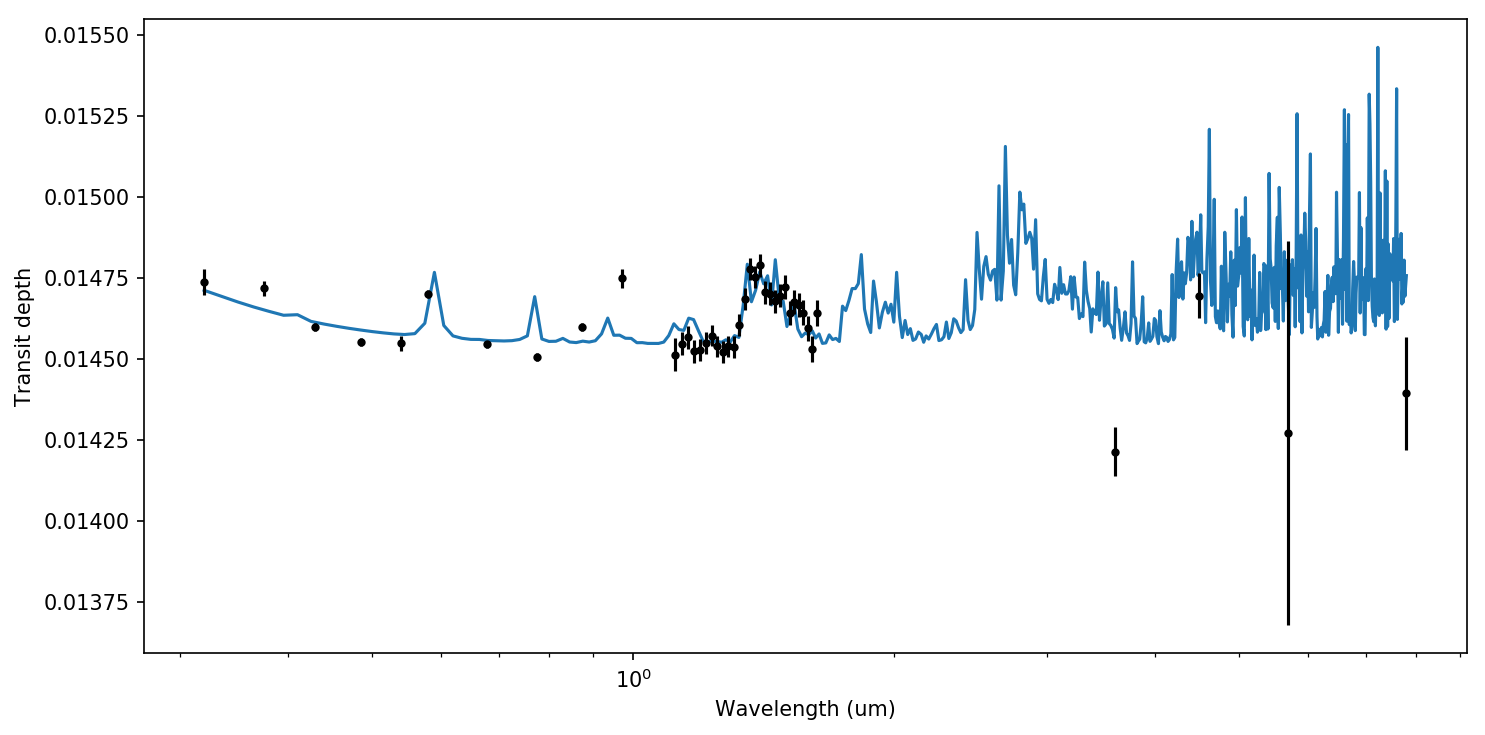

In [151]:
# Establish the Range in Wavelength to plot high resolution figures
wave_min = wave_bins.min()
wave_max = wave_bins.max()
print('{:.3f} - {:.1f} {}'.format(wave_min*1e6,wave_max*1e6, 'microns'))

wave_data = np.mean(wave_bins, axis=1)

plot_high_res_model_and_data(wave_data=wave_data, t_depths=depths, td_errors=errors, result=result, fit_info=fit_info)

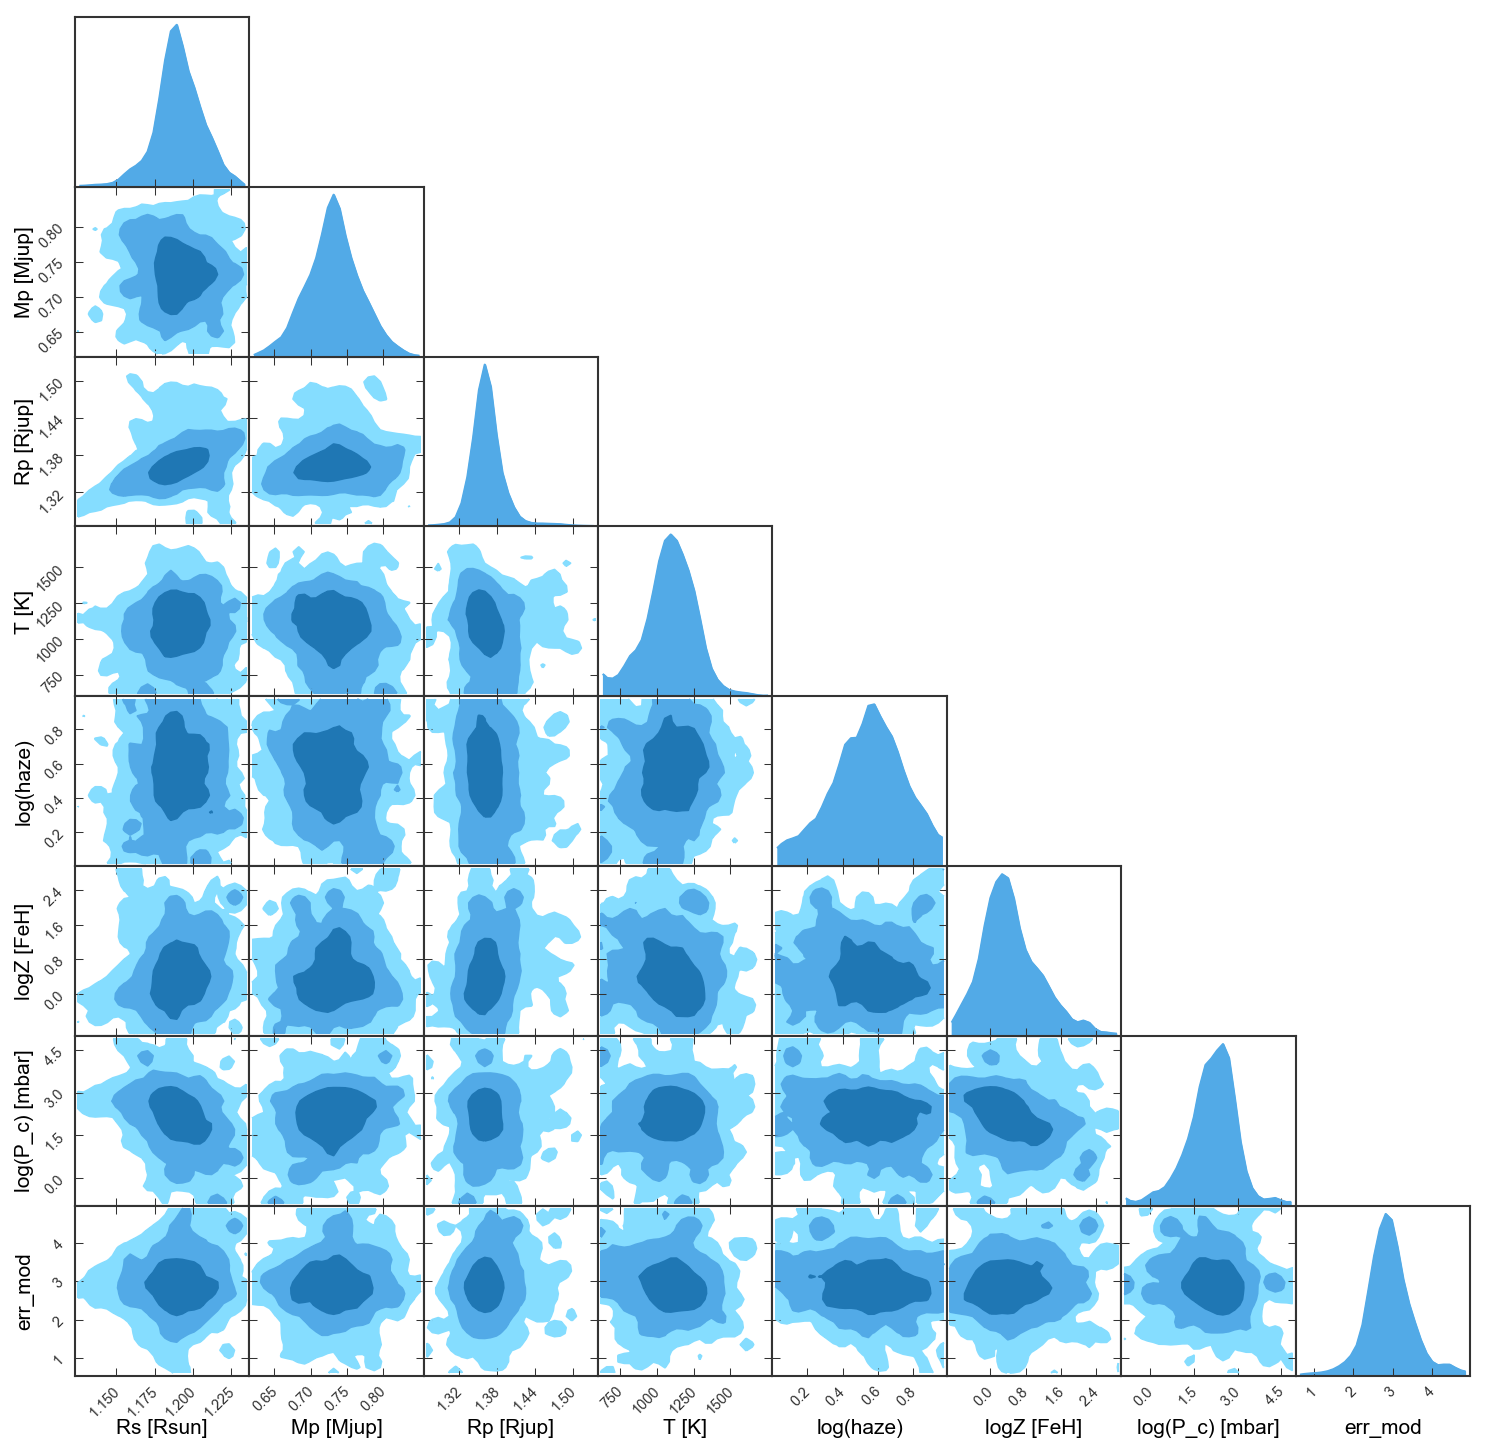

In [154]:
fit_param_names = ['Rs [Rsun]', 'Mp [Mjup]', 'Rp [Rjup]', 'T [K]', 'log(haze)', 'logZ [FeH]', 'log(P_c) [mbar]', 'err_mod']
plot_gtc_platon(result, fit_info, bayesian_model='emcee', fit_param_names=fit_param_names, nContourLevels=3)